In [229]:
# Usei como base esse tutorial:
# https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/keras/regression.ipynb#scrollTo=f-OHX4DiXd8x

# Sequential model

*Dense model 16*
*Dense model 16*
*Dense model 8*
*Dense model 4*
*Epoch 350*

_MSE: 1.31_
epoch: 350

Activation: softplus
Optimizer: Adam

15/15 - 0s - loss: 0.6325 - mae: 0.5830 - mse: 0.6325
Testing set Mean Abs Error:  0.58 ibova_0

In [230]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [231]:
dataset_path = 'final_ibova_oil_usd_ROC2.csv'
raw_dataset = pd.read_csv(dataset_path, sep=",")

dataset = raw_dataset.copy()

In [232]:
# Ver se settar os maximos positivos 
# Verificar se o fit ja ta 'normalizando' os valores max e min da base
# 
# Pra transformar em dados mais constantes 
# Scaller e desvio padrao 1 
# 
# 
# dataset

In [233]:
train_dataset = dataset.head(1914)
train_dataset = train_dataset.drop(['oil_0','usd_0'], axis=1)
train_labels = train_dataset.pop('ibova_0')

test_dataset = dataset.tail(479)
test_dataset = test_dataset.drop(['oil_0','usd_0'],axis=1)
test_labels = test_dataset.pop('ibova_0')


# Inspecionando os dados

In [234]:
# sns.pairplot(train_dataset[['index','ibova_0','ibova_1','ibova_2','ibova_3','ibova_4','oil_0','oil_1','oil_2','oil_3','oil_4','usd_0','usd_1','usd_2','usd_3','usd_4']], diag_kind="kde")

In [235]:
# sns.pairplot(train_dataset[['index','ibova_0','oil_0','usd_0']], diag_kind="kde")

# Construindo o modelo

In [236]:
# Diminuir quantidade de nós 
# Funcao logistica pra optimization
# Ver se relu funciona com RMSprop

def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='softplus', input_shape=[len(train_dataset.keys())]),
    layers.Dense(8, activation='softplus'),
    layers.Dense(8, activation='softplus'),
    layers.Dense(4, activation='softplus'),
    layers.Dense(1)
  ])

  # optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_75 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_76 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_77 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 5         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


## Testando o modelo

In [237]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
# example_result

# Treinado o modelo

In [238]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500 

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [239]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,5.495142,1.768737,5.495142,4.369033,1.642690,4.369033,495
496,5.238421,1.716239,5.238421,3.935278,1.552253,3.935278,496
497,5.301714,1.724408,5.301714,4.096779,1.582106,4.096779,497
498,5.194420,1.709396,5.194420,5.204994,1.830984,5.204994,498
499,5.363211,1.739751,5.363211,3.956591,1.562998,3.956591,499


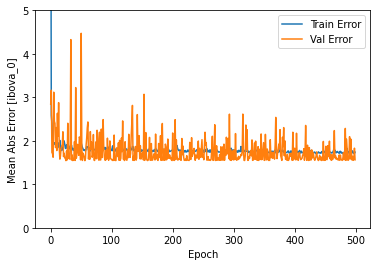

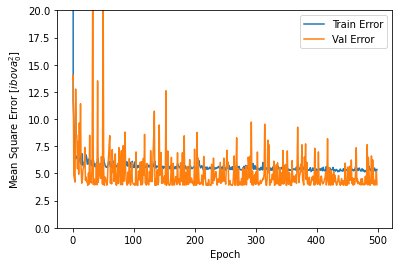

In [240]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ibova_0]')
  plt.plot(hist['epoch'], hist['mae'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ibova_0^2$]')
  plt.plot(hist['epoch'], hist['mse'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


............................

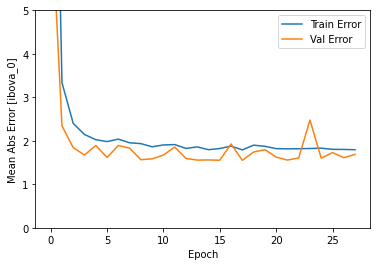

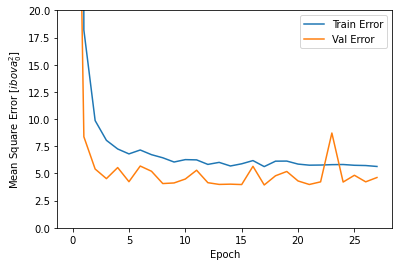

In [241]:
model = build_model()

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [242]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print(f"Testing set Mean Abs Error: {mse:5.2f} ibova_0")

15/15 - 0s - loss: 8.5626 - mae: 1.9361 - mse: 8.5626
Testing set Mean Abs Error:  8.56 ibova_0


# Realizando as previsões

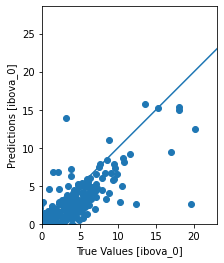

In [243]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [ibova_0]')
plt.ylabel('Predictions [ibova_0]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

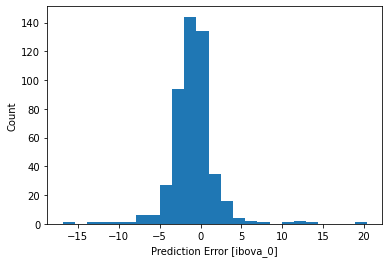

In [244]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [ibova_0]")
_ = plt.ylabel("Count")

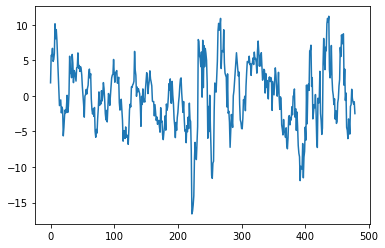

In [245]:
# Imprimindo valores reais
ibova_test = raw_dataset.ibova_0[:479]
plt.plot(ibova_test)

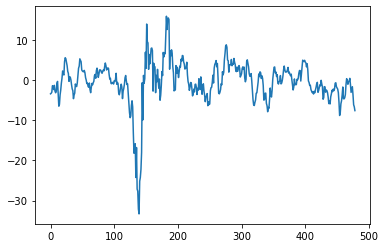

In [246]:
# Imprimindo previsoes
plt.plot(test_predictions)

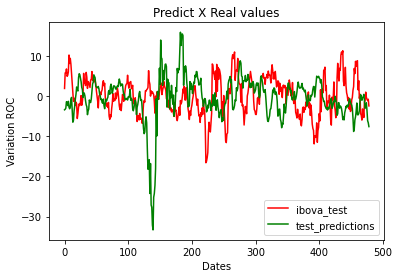

In [251]:
# Predictt X Real values
plt.plot(ibova_test, color ='r', label='ibova_test')
plt.plot(test_predictions, color ='g', label='test_predictions')
plt.xlabel("Dates")
plt.ylabel("Variation ROC")
plt.title("Predict X Real values")
plt.legend()
plt.show()

In [248]:
# Analisando Medias:

print(f'Massa de teste: {test_predictions.mean()}')
print(f'Massa inicial: {ibova_test.mean()}')
print(f'Diferenças das médias: {ibova_test.mean() - test_predictions.mean()}')

Massa de teste: -0.5449560284614563
Massa inicial: -0.04006845527306592
Diferenças das médias: 0.5048875731883904


In [249]:
# train_dataset

In [250]:
# test_dataset